**Main imports**

In [43]:
import math
import numpy as np
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms 
import matplotlib.pyplot as plt
from IPython import display as disp
import time
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


**Import dataset**

In [2]:
# helper function to make getting another batch of data easier
def cycle(iterable):
    while True:
        for x in iterable:
            yield x

#helper function for unnormalizing data for viewing
def inverse_normalize(tensor, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):
    mean = torch.as_tensor(mean, dtype=tensor.dtype, device=tensor.device)
    std = torch.as_tensor(std, dtype=tensor.dtype, device=tensor.device)
    if mean.ndim == 1:
        mean = mean.view(-1, 1, 1)
    if std.ndim == 1:
        std = std.view(-1, 1, 1)
    tensor.mul_(std).add_(mean)
    return tensor

class_names = ['apple','aquarium_fish','baby','bear','beaver','bed','bee','beetle','bicycle','bottle','bowl','boy','bridge','bus','butterfly','camel','can','castle','caterpillar','cattle','chair','chimpanzee','clock','cloud','cockroach','couch','crab','crocodile','cup','dinosaur','dolphin','elephant','flatfish','forest','fox','girl','hamster','house','kangaroo','computer_keyboard','lamp','lawn_mower','leopard','lion','lizard','lobster','man','maple_tree','motorcycle','mountain','mouse','mushroom','oak_tree','orange','orchid','otter','palm_tree','pear','pickup_truck','pine_tree','plain','plate','poppy','porcupine','possum','rabbit','raccoon','ray','road','rocket','rose','sea','seal','shark','shrew','skunk','skyscraper','snail','snake','spider','squirrel','streetcar','sunflower','sweet_pepper','table','tank','telephone','television','tiger','tractor','train','trout','tulip','turtle','wardrobe','whale','willow_tree','wolf','woman','worm',]

batch_size = 2**6
print(batch_size)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.CIFAR100('data', train=False, download=True, transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])),
    batch_size=batch_size, drop_last=True)

test_iterator = iter(cycle(test_loader))


64
Files already downloaded and verified


In [3]:
class DSC(nn.Module):
    '''https://arxiv.org/pdf/1704.04861.pdf
    depthwise seperable convolution. 
    a seperate conv is applied to each channel this is done using 
    groups = channels_in,
    then a pointwise is used to generate new channels
    '''
    
    def __init__(self, chan_in, chan_out, k=3, stride=1, pad=1):
        super(DSC, self).__init__()
        self.depthwise = nn.Sequential(
            nn.Conv2d(chan_in, chan_in, kernel_size = k, stride=stride, padding=pad, groups=chan_in, bias=None),
            nn.BatchNorm2d(chan_in),
            nn.LeakyReLU()
        )
        self.pointwise = nn.Sequential(
            nn.Conv2d(chan_in, chan_out, kernel_size = 1, stride=1, padding=0, bias=None),
            nn.BatchNorm2d(chan_out),
            nn.LeakyReLU()
        )
    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x

In [27]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.utils import save_image
from math import log2
import numpy as np
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

dataset = torchvision.datasets.CIFAR100('data', train=True, download=True, transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

    ]))
DEVICE = device
START_TRAIN_AT_IMG_SIZE = 4
LEARNING_RATE           = 1e-3
BATCH_SIZES             = [32, 32, 32, 16] #you can use [32, 32, 32, 16, 16, 16, 16, 8, 4] for example if you want to train until 1024x1024, but again this numbers depend on your vram
image_size              = 32
CHANNELS_IMG            = 3
Z_DIM                   = 256  # should be 512 in original paper
IN_CHANNELS             = 256  # should be 512 in original paper
LAMBDA_GP               = 10
PROGRESSIVE_EPOCHS      = [10000, 10000, 10000, 20000]

Files already downloaded and verified


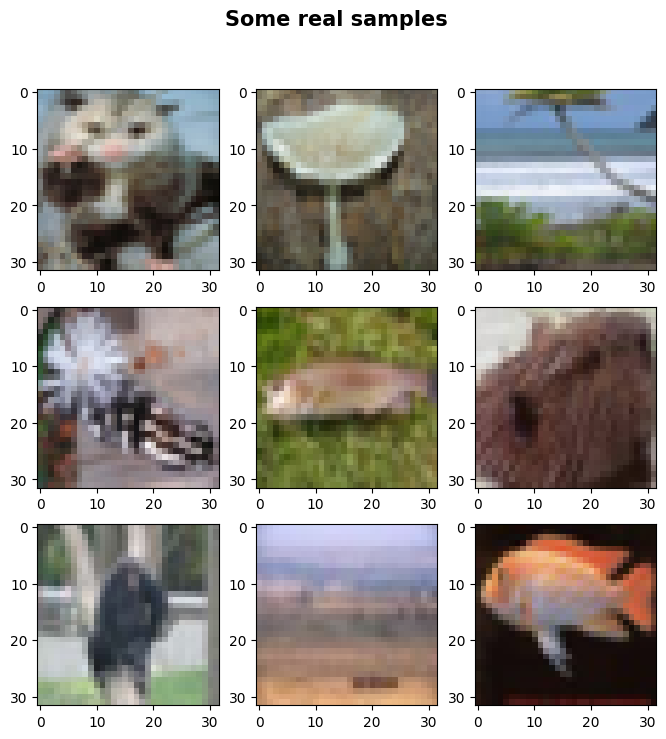

In [28]:
from math import log2
def get_loader(image_size):
    #need to create a dataloader for each image size
    transform = transforms.Compose(
        [
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.Normalize(
                [0.5,0.5,0.5], [0.5,0.5,0.5],
            )
        ]
    )
    dataset = torchvision.datasets.CIFAR100('data', train=True, transform=transform)
    batch_size = BATCH_SIZES[int(log2(image_size / 4))]
    loader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True,
    )
    return loader, dataset
def check_loader():
    loader,_ = get_loader(32)
    cloth ,_ = next(iter(loader))
    _, ax    = plt.subplots(3,3, figsize=(8,8))
    plt.suptitle('Some real samples', fontsize=15, fontweight='bold')
    ind = 0 
    for k in range(3):
        for kk in range(3):
            ind += 1
            ax[k][kk].imshow((cloth[ind].permute(1,2,0)+1)/2) 
check_loader()

In [42]:
factors = [1, 1 / 2, 1 / 4, 1 / 8]
display_steps = 1000
class WSConv2d(nn.Module):

    def __init__(
        self, in_channels, out_channels, kernel_size=3, stride=1, padding=1,
    ):
        super(WSConv2d, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size, stride, padding, groups=in_channels)
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size = 1, stride=1, padding=0)
        self.depthwise_scale     = (2 / (in_channels * (kernel_size ** 2))) ** 0.5
        self.pointwise_scale     = (2 / (in_channels)) ** 0.5
        self.depthwise_bias      = self.depthwise.bias #Copy the bias of the current column layer
        self.depthwise.bias = None      #Remove the bias
        self.pointwise_bias      = self.pointwise.bias #Copy the bias of the current column layer
        self.pointwise.bias = None 

        # initialize conv layer
        nn.init.normal_(self.depthwise.weight)
        nn.init.zeros_(self.depthwise_bias)
        nn.init.normal_(self.pointwise.weight)
        nn.init.zeros_(self.pointwise_bias)

    def forward(self, x):
        x = self.depthwise(x * self.depthwise_scale) + self.depthwise_bias.view(1, self.depthwise_bias.shape[0], 1, 1)
        return self.pointwise(x * self.pointwise_scale) + self.pointwise_bias.view(1, self.pointwise_bias.shape[0], 1, 1)
class PixelNorm(nn.Module):
    def __init__(self):
        super(PixelNorm, self).__init__()
        self.epsilon = 1e-8

    def forward(self, x):
        return x / torch.sqrt(torch.mean(x ** 2, dim=1, keepdim=True) + self.epsilon)    
    
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, use_pixelnorm=True):
        super(ConvBlock, self).__init__()
        self.use_pn = use_pixelnorm
        self.conv1  = WSConv2d(in_channels, out_channels)
        self.conv2  = WSConv2d(out_channels, out_channels)
        self.leaky  = nn.LeakyReLU(0.2)
        self.pn     = PixelNorm()

    def forward(self, x):
        x = self.leaky(self.conv1(x))
        x = self.pn(x) if self.use_pn else x
        x = self.leaky(self.conv2(x))
        x = self.pn(x) if self.use_pn else x
        return x
    

class generator(nn.Module):

    def __init__(self, z_dim, in_channels, img_channels=3):
        super(generator, self).__init__()

        # initial takes 1x1 -> 4x4
        self.initial = nn.Sequential(
            PixelNorm(),
            nn.ConvTranspose2d(z_dim, in_channels, 4, 1, 0),
            nn.LeakyReLU(0.2),
            WSConv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            PixelNorm(),
        )

        self.initial_rgb = WSConv2d(
            in_channels, img_channels, kernel_size=1, stride=1, padding=0
        )
        self.prog_blocks, self.rgb_layers = (
            nn.ModuleList([]),
            nn.ModuleList([self.initial_rgb]),
        )

        for i in range(
            len(factors) - 1
        ):  # -1 to prevent index error because of factors[i+1]
            conv_in_c  = int(in_channels * factors[i])
            conv_out_c = int(in_channels * factors[i + 1])
            self.prog_blocks.append(ConvBlock(conv_in_c, conv_out_c))
            self.rgb_layers.append(
                WSConv2d(conv_out_c, img_channels, kernel_size=1, stride=1, padding=0)
            )

    def fade_in(self, alpha, upscaled, generated):
        # alpha should be scalar within [0, 1], and upscale.shape == generated.shape
        return torch.tanh(alpha * generated + (1 - alpha) * upscaled)

    def forward(self, x, alpha, steps):
        out = self.initial(x)

        if steps == 0:
            return self.initial_rgb(out)

        for step in range(steps):
            upscaled = F.interpolate(out, scale_factor=2, mode="nearest")
            out = self.prog_blocks[step](upscaled)

        # The number of channels in upscale will stay the same, while
        # out which has moved through prog_blocks might change. To ensure
        # we can convert both to rgb we use different rgb_layers
        # (steps-1) and steps for upscaled, out respectively
        final_upscaled = self.rgb_layers[steps - 1](upscaled)
        final_out = self.rgb_layers[steps](out)
        return self.fade_in(alpha, final_upscaled, final_out)

G = generator(Z_DIM, IN_CHANNELS, 3).to(device)
G_optim = torch.optim.Adam(G.parameters(), lr=0.0002)
G_params = len(torch.nn.utils.parameters_to_vector(G.parameters()))
from tqdm import tqdm
class Discriminator(nn.Module):
    def __init__(self, in_channels, img_channels=3):
        super(Discriminator, self).__init__()
        self.prog_blocks, self.rgb_layers = nn.ModuleList([]), nn.ModuleList([])
        self.leaky = nn.LeakyReLU(0.2)

        # here we work back ways from factors because the discriminator
        # should be mirrored from the generator. So the first prog_block and
        # rgb layer we append will work for input size 1024x1024, then 512->256-> etc
        for i in range(len(factors) - 1, 0, -1):
            conv_in = int(in_channels * factors[i])
            conv_out = int(in_channels * factors[i - 1])
            self.prog_blocks.append(ConvBlock(conv_in, conv_out, use_pixelnorm=False))
            self.rgb_layers.append(
                WSConv2d(img_channels, conv_in, kernel_size=1, stride=1, padding=0)
            )

        # perhaps confusing name "initial_rgb" this is just the RGB layer for 4x4 input size
        # did this to "mirror" the generator initial_rgb
        self.initial_rgb = WSConv2d(
            img_channels, in_channels, kernel_size=1, stride=1, padding=0
        )
        self.rgb_layers.append(self.initial_rgb)
        self.avg_pool = nn.AvgPool2d(
            kernel_size=2, stride=2
        )  # down sampling using avg pool

        # this is the block for 4x4 input size
        self.final_block = nn.Sequential(
            # +1 to in_channels because we concatenate from MiniBatch std
            WSConv2d(in_channels + 1, in_channels, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2),
            WSConv2d(in_channels, in_channels, kernel_size=4, padding=0, stride=1),
            nn.LeakyReLU(0.2),
            WSConv2d(
                in_channels, 1, kernel_size=1, padding=0, stride=1
            ),  # we use this instead of linear layer
        )

    def fade_in(self, alpha, downscaled, out):
        """Used to fade in downscaled using avg pooling and output from CNN"""
        # alpha should be scalar within [0, 1], and upscale.shape == generated.shape
        return alpha * out + (1 - alpha) * downscaled

    def minibatch_std(self, x):
        batch_statistics = (
            torch.std(x, dim=0).mean().repeat(x.shape[0], 1, x.shape[2], x.shape[3])
        )
        # we take the std for each example (across all channels, and pixels) then we repeat it
        # for a single channel and concatenate it with the image. In this way the discriminator
        # will get information about the variation in the batch/image
        return torch.cat([x, batch_statistics], dim=1)

    def forward(self, x, alpha, steps):
        # where we should start in the list of prog_blocks, maybe a bit confusing but
        # the last is for the 4x4. So example let's say steps=1, then we should start
        # at the second to last because input_size will be 8x8. If steps==0 we just
        # use the final block
        cur_step = len(self.prog_blocks) - steps

        # convert from rgb as initial step, this will depend on
        # the image size (each will have it's on rgb layer)
        out = self.leaky(self.rgb_layers[cur_step](x))

        if steps == 0:  # i.e, image is 4x4
            out = self.minibatch_std(out)
            return self.final_block(out).view(out.shape[0], -1)

        # because prog_blocks might change the channels, for down scale we use rgb_layer
        # from previous/smaller size which in our case correlates to +1 in the indexing
        downscaled = self.leaky(self.rgb_layers[cur_step + 1](self.avg_pool(x)))
        out = self.avg_pool(self.prog_blocks[cur_step](out))

        # the fade_in is done first between the downscaled and the input
        # this is opposite from the generator
        out = self.fade_in(alpha, downscaled, out)

        for step in range(cur_step + 1, len(self.prog_blocks)):
            out = self.prog_blocks[step](out)
            out = self.avg_pool(out)

        out = self.minibatch_std(out)
        return self.final_block(out).view(out.shape[0], -1)
    
def gradient_penalty(critic, real, fake, alpha, train_step, device="cpu"):
    BATCH_SIZE, C, H, W = real.shape
    beta = torch.rand((BATCH_SIZE, 1, 1, 1)).repeat(1, C, H, W).to(device)
    interpolated_images = real * beta + fake.detach() * (1 - beta)
    interpolated_images.requires_grad_(True)
    
    # Calculate critic scores
    mixed_scores = critic(interpolated_images, alpha, train_step)
 
    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty

def generate_examples(gen,alpha, dataloader, steps):
    disp.clear_output(wait=True)  # Clear the output to make the new plots visible.

    gen.eval()

    # Get a batch of real images
    real_images, _ = next(iter(dataloader))
    real_images = real_images.to(DEVICE)

    # Generate a batch of images
    noise = torch.randn(real_images.size(0), Z_DIM, 1, 1).to(DEVICE)
    generated_images = gen(noise, 1, steps).detach().cpu()

    # Make grids
    real_images_grid = torchvision.utils.make_grid(real_images.cpu() * 0.5 + 0.5)
    generated_images_grid = torchvision.utils.make_grid(generated_images * 0.5 + 0.5)

    # Plot real images
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(real_images_grid.numpy().transpose(1, 2, 0))
    plt.title('Real Images')
    plt.axis('off')

    # Plot generated images
    plt.subplot(1, 2, 2)
    plt.imshow(generated_images_grid.numpy().transpose(1, 2, 0))
    plt.title('Generated Images')
    plt.axis('off')

    plt.show()

    gen.train()


def train_fn(
    critic,
    gen,
    loader,
    dataset,
    step,
    alpha,
    opt_critic,
    opt_gen,
    itteration,
):
    loader = iter(cycle(loader))
    G_loss_arr, D_loss_arr = [],[]
    for _ in range(display_steps):
        real, y = next(loader)
        real = real.to(DEVICE)
        cur_batch_size = real.shape[0]

        # Train Critic: max E[critic(real)] - E[critic(fake)] <-> min -E[critic(real)] + E[critic(fake)]
        # which is equivalent to minimizing the negative of the expression
        noise = torch.randn(cur_batch_size, Z_DIM, 1, 1).to(DEVICE)

        fake = gen(noise, alpha, step)
        critic_real = critic(real, alpha, step)
        critic_fake = critic(fake.detach(), alpha, step)
      
        gp = gradient_penalty(critic, real, fake, alpha, step, device=DEVICE)
        loss_critic = (
            -(torch.mean(critic_real) - torch.mean(critic_fake))
            + LAMBDA_GP * gp
            + (0.001 * torch.mean(critic_real ** 2))
        )

        critic.zero_grad()
        loss_critic.backward()
        opt_critic.step()

        # Train Generator: max E[critic(gen_fake)] <-> min -E[critic(gen_fake)]
        gen_fake = critic(fake, alpha, step)
        loss_gen = -torch.mean(gen_fake)
        
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        # Update alpha and ensure less than 1
        alpha += cur_batch_size / (
            (PROGRESSIVE_EPOCHS[step] * 0.5) * len(dataset)
        )
        alpha = min(alpha, 1)
        if step%display_steps == 0:
            G_loss_arr.append([steps, loss_gen.item()])
            D_loss_arr.append([steps, loss_critic.item()])
        itteration += 1
        

    return alpha, D_loss_arr, G_loss_arr, real.cpu(), fake.cpu(), itteration

D_loss_arr = []
G_loss_arr = []
critic = Discriminator(IN_CHANNELS).to(device)

D_params = len(torch.nn.utils.parameters_to_vector(critic.parameters()))
criterion = nn.BCEWithLogitsLoss()

print(f'> Number of model parameters {G_params + D_params}')
if (G_params + D_params) > 1000000:
    print("> Warning: you have gone over your parameter budget and will have a grade penalty!")


# initialize gen and disc, note: discriminator we called critic,
# according to WGAN paper (since it no longer outputs between [0, 1])
gen = generator(
    Z_DIM, IN_CHANNELS, img_channels=3
).to(DEVICE)
critic = Discriminator(
    IN_CHANNELS, img_channels=CHANNELS_IMG
).to(DEVICE)

# initialize optimizers
opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.99))
opt_critic = optim.Adam(
    critic.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.99)
)


gen.train()
critic.train()
itteration_count = 0
temp=0
step = int(log2(START_TRAIN_AT_IMG_SIZE / 4))
while itteration_count<50000:
    for num_steps in PROGRESSIVE_EPOCHS:
        print(num_steps)
        alpha = 1e-5  # start with very low alpha, you can start with alpha=0
        loader, dataset = get_loader(4 * 2 ** step)  # 4->0, 8->1, 16->2, 32->3, 64 -> 4
        print(f"Current image size: {4 * 2 ** step}")
        counter = 0
        for itteration in range(int(num_steps/display_steps)):#num_epochs
            
            print(f"Itteration [{counter}/{int(num_steps/display_steps)}]")
            alpha, D_loss, G_loss, real, fake, temp = train_fn(
                critic,
                gen,
                loader,
                dataset,
                step,
                alpha,
                opt_critic,
                opt_gen,
                itteration
            )
            itteration_count += temp
            D_loss_arr += np.mean(D_loss)
            G_loss_arr += np.mean(G_loss)
            generate_examples(gen, alpha, loader, step)
            counter += 1
            print(f'\nLoss of generator [{np.mean(G_loss)}]\nLoss of critic [{np.mean(D_loss)}]')
        
        step += 1  # progress to the next img size

> Number of model parameters 1469391
> Warning: you have gone over your parameter budget and will have a grade penalty!
10000
Current image size: 4
Itteration [0/10]


KeyboardInterrupt: 

**Latent interpolations**

**FID scores**

Evaluate the FID from 10k of your model samples (do not sample more than this) and compare it against the 10k test images. Calculating FID is somewhat involved, so we use a library for it. It can take a few minutes to evaluate. Lower FID scores are better.

In [24]:
%%capture
!pip install clean-fid
import os
from cleanfid import fid
import shutil
from torchvision.utils import save_image

In [26]:
# define directories
real_images_dir = 'real_images'
generated_images_dir = 'generated_images'
num_samples = 10000 # do not change

# create/clean the directories
def setup_directory(directory):
    if os.path.exists(directory):
        shutil.rmtree(directory) # remove any existing (old) data
    os.makedirs(directory)

setup_directory(real_images_dir)
setup_directory(generated_images_dir)

# generate and save 10k model samples
num_generated = 0
while num_generated < num_samples:

    # sample from your model, you can modify this
    noise = torch.randn(64, Z_DIM, 1, 1).to(DEVICE)
    
    samples_batch = G(noise, alpha, step).cpu().detach()

    for image in samples_batch:
        if num_generated >= num_samples:
            break
        save_image(image, os.path.join(generated_images_dir, f"gen_img_{num_generated}.png"))
        num_generated += 1

# save 10k images from the CIFAR-100 test dataset
num_saved_real = 0
while num_saved_real < num_samples:
    real_samples_batch, _ = next(test_iterator)
    for image in real_samples_batch:
        if num_saved_real >= num_samples:
            break
        save_image(image, os.path.join(real_images_dir, f"real_img_{num_saved_real}.png"))
        num_saved_real += 1

NameError: name 'cur_batch_size' is not defined

In [ ]:
# compute FID
score = fid.compute_fid(real_images_dir, generated_images_dir, mode="clean")
print(f"FID score: {score}")